# Classifying Yelp Reviews (Classifying Sentiment of Restaurant Reviews, chapter 3)

### Source: Chapter 3, Natural Language Processing with Pytorch. (2019). Delip Rao and Brian McMahan. O’Reilly: source code available on https://github.com/joosthub/PyTorchNLPBook

### PyTorch tutorial: refer to https://pytorch.org/tutorials/

## Imports

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = {idx: token          
                              for token, idx in self._token_to_idx.items()} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)  # self.unk_index set to 0
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

1. Vocabulary 类
作用
Vocabulary 主要用于 构建和管理词汇表，它提供了：

token（词）到索引的映射 (_token_to_idx)
索引到 token 的映射 (_idx_to_token)
处理未登录词（UNK） 的能力
支持动态添加新 token

### The Vectorizer

In [ ]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers; {'negative':0, 'positive':1}
        """
        self.review_vocab = review_vocab     # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
        self.rating_vocab = rating_vocab     # {'negative':0, 'positive':1}

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding   
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)  # E.g., the one_hot vector size: 1792
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot  # E.g., "Unfortunately, the frustration of being Dr. Go..." -> [0, 0, 1, 0, 1, ....., 0, 0]

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cls: class name, i.e. ReviewVectorizer
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
            frequency_cutoff 是 词频阈值，用于 控制加入词汇表的单词数量。
                            在 ReviewVectorizer.from_dataframe() 方法中，它会 统计每个单词的出现次数。
                            如果某个单词出现次数少于 frequency_cutoff，就不会加入词汇表。
                            这样可以 过滤掉低频词，减少噪声，提高模型的训练效率。
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)   # create an instance of Vocabulary class
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):  
            rating_vocab.add_token(rating)            # {'negative':0, 'positive':1}

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:    # ignore punctuation tokens忽略标点符号
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)          # {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}

        return cls(review_vocab, rating_vocab)

2. ReviewVectorizer 类

作用
ReviewVectorizer 将文本转换为向量（one-hot 形式），以便用于机器学习或深度学习模型进行训练。
它管理两个 Vocabulary：
review_vocab：存储 文本单词 到索引的映射
rating_vocab：存储 类别标签 到索引的映射（如 negative:0, positive:1）

什么是 One-Hot 形式？
One-hot encoding（独热编码） 是一种 表示分类数据的方式，通常用于自然语言处理（NLP）和机器学习。它的基本思想是：

每个类别（单词、标签等）用一个 长度固定的二进制向量 表示。
在这个向量中，只有一个位置是 1，其余都是 0。
这个 1 对应的索引就是该类别的唯一标识。

### The Dataset

In [5]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)        # E.g., 3918

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)     # E.g., 840

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)          # E.g., 840

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv, frequency_cutoff):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cls: class name, i.e. ReviewDataset
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df, frequency_cutoff))
    
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,           #  e.g., { 'x_data': [0, 0, 1, 0, 1, ....., 0, 0],
                'y_target': rating_index}          #          'y_target': 0  }

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  # the floor division "//" rounds the result down to the nearest whole number
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the cpu or gpu device location.
    """
    # drop_last: set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. 
    # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)
    # need to use sampler option for balanced data: 
    # https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_data & y_target
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

3. dataset
作用：管理文本数据集，并提供 PyTorch 兼容的数据加载方式.
ReviewDataset 主要用于 管理文本数据集，并提供 与 PyTorch 兼容的 Dataset 类，用于机器学习模型的训练、验证和测试。

它支持：
    3.1 自动加载数据集（CSV 格式）
    3.2 数据集拆分（train/val/test）
    3.3 向量化文本数据（将文本转换为 one-hot 编码）
    3.4 为 PyTorch DataLoader 提供索引访问（__getitem__ 方法）
    3.5 生成 mini-batches 供模型训练（generate_batches 方法）


## The Model: ReviewClassifier

In [6]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features, hidden_dim):
        """
        Args:
            num_features (int): the size of the input feature vector
            hidden_dim   (int): the size of hidden dimension
            📌 num_features: 输入特征的维度（文本向量的大小）
            📌 hidden_dim: 隐藏层神经元个数（控制模型复杂度）
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim)  # E.g., num_features: 1792; hidden_dim: 20
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=1)

    def forward(self, x_in):
        """The forward pass of the classifier    
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be [batch, num_features]
        Returns:
            the resulting tensor. tensor.shape should be [batch]
        """
        intermediate = self.fc1(x_in)            # [batch, num_features] -> [batch, hidden_dim] ; E.g., [128,1792]->[128,20]
        intermediate = F.relu(intermediate)      # [batch, hidden_dim] ; E.g., [128,20]
        y_out = self.fc2(intermediate)           # [batch, hidden_dim] -> [batch, out_features] ; E.g., [128,20]->[128,1]
            
        """
        fc: Fully Connected（全连接） 
        网络架构
            fc1：线性变换层（num_features -> hidden_dim）
            ReLU 激活函数（增加非线性）
            fc2：线性变换层（hidden_dim -> 1）
            sigmoid：把输出压缩到 [0,1]，用于二分类概率
            squeeze() 作用是去掉维度 1，让 [batch_size,1] 变成 [batch_size]
        """
        return torch.sigmoid(y_out).squeeze()    # [batch, 1] -> [batch] (e.g., [0.3, 0.1, ..., 0.5]) ; E.g., [128,1]->[128]
    
    

### Excercise 
1. Add 1 additional hidden layer

code:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReviewClassifier(nn.Module):
    """ 添加额外隐藏层的 MLP 分类器 """
    def __init__(self, num_features, hidden_dim1, hidden_dim2):
        """
        Args:
            num_features (int): 输入特征数
            hidden_dim1 (int): 第一隐藏层的神经元数
            hidden_dim2 (int): 第二隐藏层的神经元数
        """
        super(ReviewClassifier, self).__init__()
        
        self.fc1 = nn.Linear(in_features=num_features, out_features=hidden_dim1)  # 输入 -> 隐藏层1
        self.fc2 = nn.Linear(in_features=hidden_dim1, out_features=hidden_dim2)   # 隐藏层1 -> 隐藏层2
        self.fc3 = nn.Linear(in_features=hidden_dim2, out_features=1)  # 隐藏层2 -> 输出层

    def forward(self, x_in):
        """ 前向传播
        Args:
            x_in (torch.Tensor): 输入数据张量 [batch_size, num_features]
        Returns:
            tensor: 预测概率 [batch_size]
        """
        x = F.relu(self.fc1(x_in))  # 经过第一隐藏层 + ReLU 激活
        x = F.relu(self.fc2(x))     # 经过第二隐藏层 + ReLU 激活
        y_out = torch.sigmoid(self.fc3(x))  # 输出层 + Sigmoid
        return y_out.squeeze()  # 变成 [batch_size]


## Training Routine

### Helper functions

In [7]:
def make_train_state():
    return {'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []}

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (y_pred>0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

"""
🚀 什么时候用？
✅ 需要 确保实验可复现 时（调试/论文实验）
✅ 训练 深度学习模型（如 PyTorch）时，保证每次初始化和数据加载一致
✅ 进行 超参数搜索（Hyperparameter Tuning），避免随机初始化影响结果

🚀 总结
📌 set_seed_everywhere(seed, cuda) 固定随机种子，确保可复现性 🚀
📌 影响 NumPy、PyTorch CPU、PyTorch GPU 的随机性
📌 适用于深度学习训练、实验对比、超参数搜索等场景 ✅
"""

'\n🚀 什么时候用？\n✅ 需要 确保实验可复现 时（调试/论文实验）\n✅ 训练 深度学习模型（如 PyTorch）时，保证每次初始化和数据加载一致\n✅ 进行 超参数搜索（Hyperparameter Tuning），避免随机初始化影响结果\n\n🚀 总结\n📌 set_seed_everywhere(seed, cuda) 固定随机种子，确保可复现性 🚀\n📌 影响 NumPy、PyTorch CPU、PyTorch GPU 的随机性\n📌 适用于深度学习训练、实验对比、超参数搜索等场景 ✅\n'

### Settings and some prep work

In [9]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    review_csv='data/yelp/reviews_with_splits_lite.csv',
    # Model hyper parameters
    hidden_dim=20,
    # Training hyper parameters
    batch_size=128,
    learning_rate=0.001,
    num_epochs=25,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
)
  
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: True


### Excercise 
1. Change the value of frequency_cutoff to 0 for using all the terms occurring in training dataset
2. Try to explore other hyperparameters.

### Initializations

In [10]:
print("Loading dataset and creating vectorizer")
# create dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff) 

vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab), hidden_dim=args.hidden_dim)

Loading dataset and creating vectorizer


In [11]:
str(vectorizer.review_vocab), str(vectorizer.rating_vocab)

('<Vocabulary(size=1792)>', '<Vocabulary(size=2)>')

### Training loop

In [23]:
classifier = classifier.to(args.device)

loss_func = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

train_state = make_train_state()

epoch_bar = tqdm(desc='training routine', total=args.num_epochs)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), leave=True)

try:
    for epoch_index in range(args.num_epochs):
 
        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float()) # [batch, num_features]->[batch] ; E.g., [128,1792]->[128]

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float()) # ([batch],[batch])->scalar ; E.g., ([128],[128])-> 0.69
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target']) # ([batch],[batch])->scalar ; E.g., ([128],[128])-> 55.34
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss) # train_loss for each epoch
        train_state['train_acc'].append(running_acc)   # train_acc for each epoch

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float()) # [batch, num_features]->[batch] ; E.g., [128,1792]->[128]

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)   # val_loss for each epoch
        train_state['val_acc'].append(running_acc)     # val_acc for each epoch

        train_bar.n = 1  # reset number of finished iterations
        val_bar.n = 1
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/25 [00:00<?, ?it/s]

split=train:   0%|          | 0/30 [00:00<?, ?it/s]

split=val:   0%|          | 0/6 [00:00<?, ?it/s]

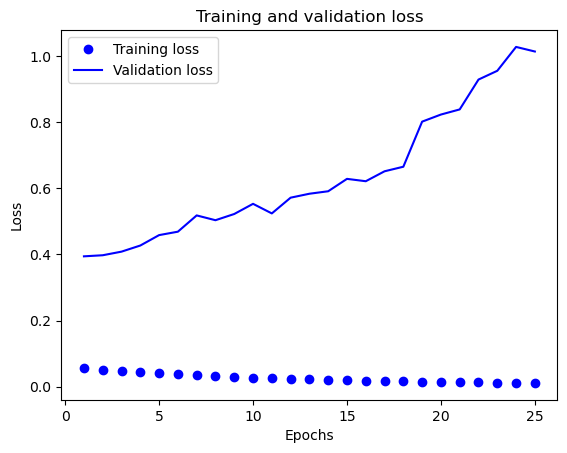

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

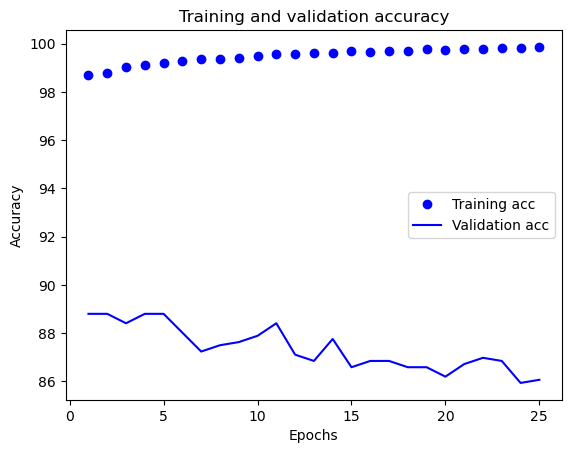

In [25]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# compute the loss & accuracy on the test set using the best available model

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []    # store predicted values for confusion matrix
y_target_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())   # [batch, num_features]->[batch] ; E.g., [128,1792]->[128]
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend((y_pred>0.5).cpu().long().numpy())      # E.g., [128] -> [1, 0, 1, 0, 0, .......]
    y_target_list.extend(batch_dict['y_target'].cpu().numpy()) # E.g., [128] -> [1, 0, 0, 0, 1, .......]
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [27]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 1.069
Test Accuracy: 84.38


In [28]:
rating_classes = []
for i in range(len(dataset._vectorizer.rating_vocab)):
    rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
print(rating_classes)

['negative', 'positive']


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       negative  positive
Predicted                    
negative        313        51
positive         69       335


In [30]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       382
           1       0.83      0.87      0.85       386

    accuracy                           0.84       768
   macro avg       0.84      0.84      0.84       768
weighted avg       0.84      0.84      0.84       768



### Prediction

In [31]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)     # E.g., convert "end." to "end . "
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)  # replace special character strings with empty string
    return text

In [32]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))  # E.g., [1792]
    result = classifier(vectorized_review.view(1, -1))  # convert a vector to a matrix; E.g., [1, 1803]->[1]
    
    probability_value = result.item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [33]:
test_review = "this is a pretty awesome book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

this is a pretty awesome book -> positive


### End

# Lab Assignment #1: due on February 26, 2025

- ### Task 1: Modify the original model using following approaches. Note that this task is meant for testing the performance change of the model with sugggested changes. So try to observe the performance change (i.e., test accuracy and loss) of each suggestion, and discuss how each change affects the results of original model. You only need to modify one of the approaches below at a time, such as setting the frequencey_cutoff to 0 without using a term frequency vector or adding one additional hidden layer. However, you are allowed to explore the best combination of these approaches. 
  1. Instead of using a term presence vector (e.g., [0, 1, 0, 0, ..., 1, 0]), use a term frequuecy vector (e.g., [0, 2, 0, 0, ..., 3, 0]).
  > need to modify vectorize() function in code cell [8].
  2. Add 1 additional hidden layer between self.fc1 and self.fc2.
  > need to modify \_\_init\_\_() and forward() functions in code cell [12].
  3. Change the value of frequency_cutoff to 0 for using all the terms occurring in training dataset.
  > need to modify the value of args in code cell [20].
 
- ### Task 2: Modify the original model to have 2 output nodes (instead of one output node) in the last layer using following guidelines. Note that you don't need to strictly follow these guidelines as long as your code generates correct results. Also note that this task is meant for learning how to modify the existing model, but not for improving the performance of the model.
  1. Change the loss funcion in code cell [26]
  > loss_func = nn.BCELoss() -> loss_func = nn.CrossEntropyLoss()
  2. Change the output features size and output of the model in code cell [12].  
  > hint: just "return y_out" since softmax() is handled by nn.CrossEntropyLoss(). 
  >> return torch.sigmoid(y_out).squeeze() -> return y_out
  3. Change compute_accuracy() in code cell [16].
  > y_pred_indices = (y_pred>0.5).cpu().long() -> y_pred_indices = y_pred.max(dim=1).indices.cpu()
  4. Change all occurences of loss_func() code as below.
  > loss = loss_func(y_pred, batch_dict['y_target'].float()) -> loss = loss_func(y_pred, batch_dict['y_target'])
  5. Need to change code in code cells [29] and [36] since the new model has 2 output nodes results, instead of one node result (refer to code change in step 3).

- ### Use data\yelp\reviews_with_splits_lite.csv as a dataset in this lab assignment.
- ### Prepare a Word or PDF report summarizing your solutions for Tasks 1 and 2. For Task 1, explain the modifications made to the original code and discuss how these changes impacted the test results. For Task 2, describe the changes made to the original code and justify your solution (i.e., why your or the suggested code was used to replace the original). The report should be up to two pages in length.

- ### Submit one zip file, named __lab-assign-no1-yourname.zip__, that contains 2 Jupyter Notebook files (one for each Task; Please ensure that you display the modified code and, if necessary, disable the original code using comments (#).), input data file (include only reviews_with_splits_lite.csv file), and a report file through Turnitin on the class website. 

- ### The Jupyter Notebook file must show all output results of your solution code. So please ensure you run all the cells in the notebook file before submitting. Also, note that Turnitin does not allow you to resubmit your lab assignment file.
- ### The lab assignment handed in after the due date will not be marked. So please submit the assignment file at least one hour before the deadline date and time. Also, ensure you get a confirmation message right after you submit the assignment file via Turnitin.